In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("/content/drive/MyDrive/,t,hf/banknote.txt", sep = ',', na_values='?')
df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [ ]:
# df = df.drop_duplicates()

In [ ]:
df.isnull().sum()

threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

<ipython-input-43-eb4295629c4f>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


Признаки приведены к единому типу.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

models_and_params = {
    'SVC': (
        SVC(),
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
    'RandomForest': (
        RandomForestClassifier(),
        {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
    ),
    'AdaBoost': (
        AdaBoostClassifier(),
        {'n_estimators': [50, 100], 'learning_rate': [0.5, 1.0]}
    )
}

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

def train_models(X, y, models_dict, test_size=0.2):
    results = {}

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42)

    for name, (model, param_grid) in models_dict.items():
        print(f"Обучение модели: {name}")
        grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        test_acc = accuracy_score(y_test, best_model.predict(X_test))

        results[name] = {
            'best_model': best_model,
            'accuracy': test_acc,
            'best_params': grid.best_params_
        }
        print(f"{name}: Accuracy = {test_acc:.3f}, Best Params = {grid.best_params_}")

    return results

In [ ]:
X = df.drop(columns='class').values
y = df['class'].values
result = train_models(X, y, models_and_params)

Обучение модели: SVC
SVC: Accuracy = 1.000, Best Params = {'C': 10, 'kernel': 'rbf'}
Обучение модели: RandomForest
RandomForest: Accuracy = 0.996, Best Params = {'max_depth': 20, 'n_estimators': 200}
Обучение модели: AdaBoost
AdaBoost: Accuracy = 1.000, Best Params = {'learning_rate': 1.0, 'n_estimators': 100}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

best_svc = SVC(C=10, kernel='rbf', random_state=42)
best_rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
best_ada = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)

models = {
    'SVC': best_svc,
    'Random Forest': best_rf,
    'AdaBoost': best_ada
}

results = {
    'train': {},
    'test': {},
    'cv': {}
}

for name, model in models.items():
    model.fit(X_train, y_train)

    results['train'][name] = accuracy_score(y_train, model.predict(X_train))
    results['test'][name] = accuracy_score(y_test, model.predict(X_test))
    results['cv'][name] = cross_val_score(model, X_train, y_train, cv=5).mean()

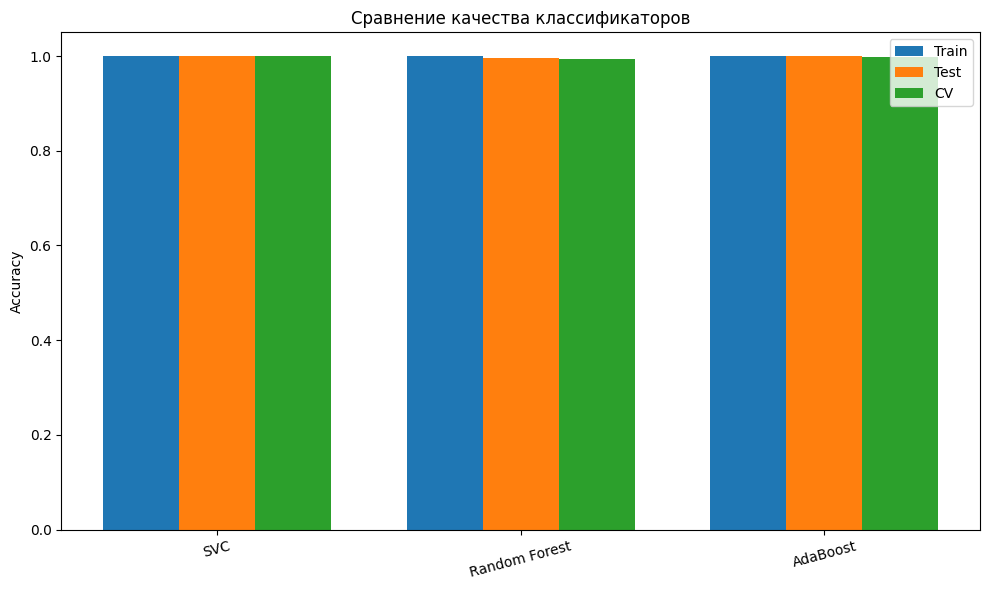

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(models.keys())
train_scores = [results['train'][name] for name in labels]
test_scores = [results['test'][name] for name in labels]
cv_scores = [results['cv'][name] for name in labels]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, train_scores, width, label='Train')
ax.bar(x, test_scores, width, label='Test')
ax.bar(x + width, cv_scores, width, label='CV')

ax.set_ylabel('Accuracy')
ax.set_title('Сравнение качества классификаторов')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.legend()
plt.tight_layout()
plt.show()

Каждая модель показала высокую accuracy, следовательно можно выбрать любую. Выберем RandomForest.

In [ ]:
best_model_name = 'Random Forest'
best_model = models[best_model_name]
print(f"Лучшая модель: {best_model_name}")

Лучшая модель: Random Forest


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
)

# Предсказания
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # для ROC AUC

# Метрики
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9964
Precision: 0.9919
Recall: 1.0000
F1 Score: 0.9959
ROC AUC: 1.0000

Confusion Matrix:
 [[152   1]
 [  0 122]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



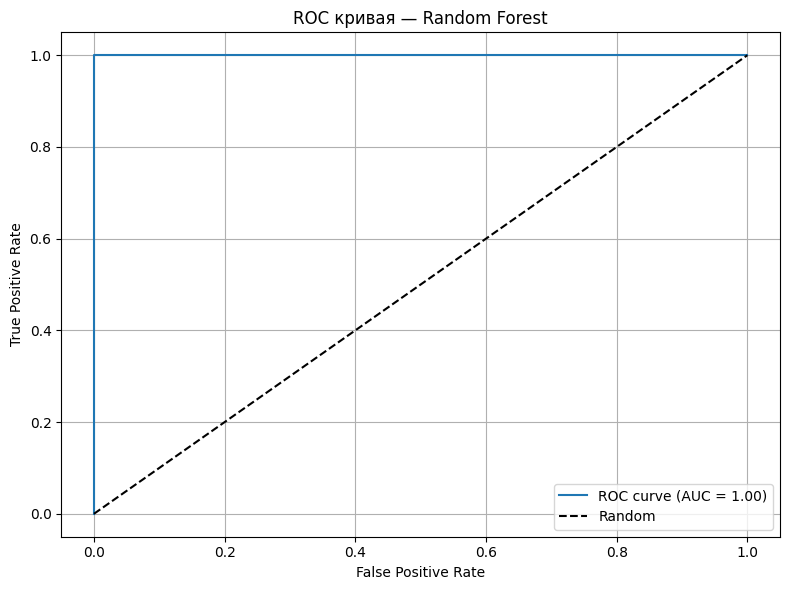

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC кривая — {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()